<a href="https://colab.research.google.com/github/popcorn195/Flower-Classifier-ML/blob/main/Flower_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installing and Fetching Libraries

In [2]:
pip install tensorflow numpy streamlit

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Dense, Dropout, Flatten

# Fetching Images from Folders

In [4]:
count=0
dirs=os.listdir('flowers/')
for dir in dirs:
  files=list(os.listdir('flowers/'+dir))
  print(dir+' folder has '+str(len(files))+' images')
  count+=len(files)
print('flowers folder has '+str(count)+' images')

daisy folder has 764 images
rose folder has 784 images
dandelion folder has 1052 images
sunflower folder has 733 images
tulip folder has 984 images
flowers folder has 4317 images


#Load images into arrays as dataset

In [5]:
base_dir='flowers/'
img_size=180
batch=32

In [6]:
train_ds=tf.keras.utils.image_dataset_from_directory(base_dir,
                                                     seed=123,
                                                     validation_split=0.2, #using 20% of the data for validation and 80% for training
                                                     subset='training', #Ensures the random shuffling and splitting of data is reproducible
                                                     batch_size=batch, #Defines how many images to process in one go
                                                     image_size=(img_size,img_size))

val_ds=tf.keras.utils.image_dataset_from_directory(base_dir,
                                                     seed=123,
                                                     validation_split=0.2,
                                                     subset='validation',
                                                     batch_size=batch,
                                                     image_size=(img_size,img_size))
#Loading your image data from disk
#Resizing images
#Labeling them based on folder names
#Splitting into training and validation
#Batching for efficient training

Found 4317 files belonging to 5 classes.
Using 3454 files for training.
Found 4317 files belonging to 5 classes.
Using 863 files for validation.


In [7]:
flower_names=train_ds.class_names
flower_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

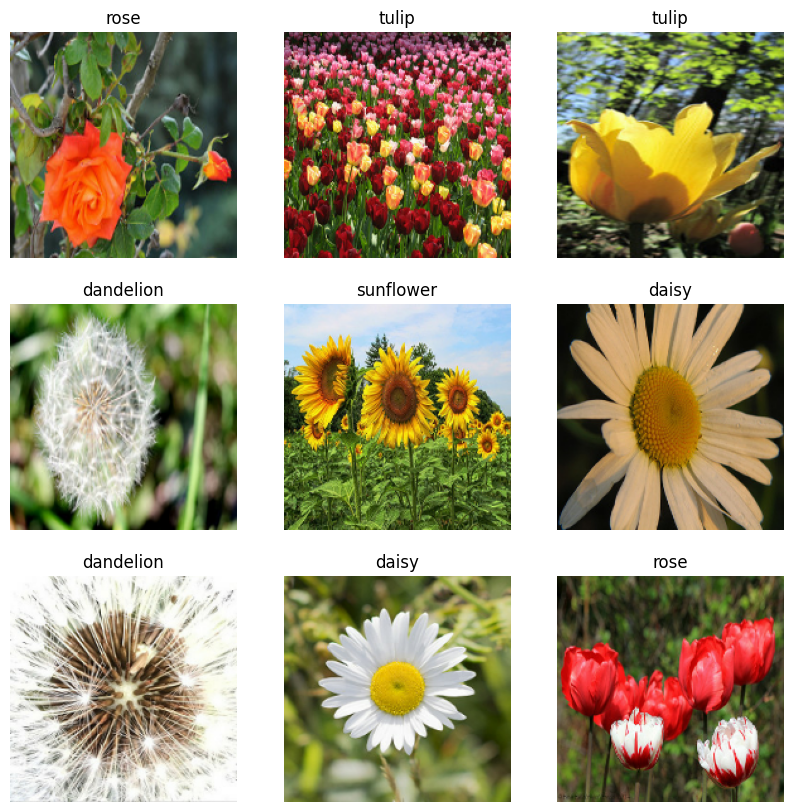

In [8]:
i=0;
plt.figure(figsize=(10,10))

for images,labels in train_ds.take(1): #take(1) grabs one batch
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    #Converts the i-th image tensor to a NumPy array
    #Casts it to uint8 so imshow can display it properly
    plt.title(flower_names[labels[i]]) #Adds a title (label) above each image
    plt.axis('off') #Hides the x and y axes

In [9]:
AUTOTUNE=tf.data.AUTOTUNE
#lets TensorFlow figure out the optimal buffer size for prefetching.

In [10]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
#cache(): Stores the dataset in memory, without it, images would be reloaded from disk every epoch
#shuffle(1000): Randomly shuffles the dataset using a buffer of 1000 samples. This helps prevent your model from learning the order of the data.
#prefetch(buffer_size=AUTOTUNE): Allows the pipeline to prepare the next batch while the current one is being processed by the GPU.

In [11]:
val_ds=val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#Data Augumentation

In [13]:
data_augumentation=Sequential([
    layers.RandomFlip("horizontal",input_shape=(img_size,img_size,3)),
    #Flips the image left-to-right at random
    layers.RandomRotation(0.1),
    #Randomly rotates the image up to ±10% of 360° (≈36°)
    layers.RandomZoom(0.1)
    #Randomly zooms in/out by ±10%
])

#Randomly flips, rotates, and zooms images
#Helps model generalize better
#Runs only during training, not validation/testing

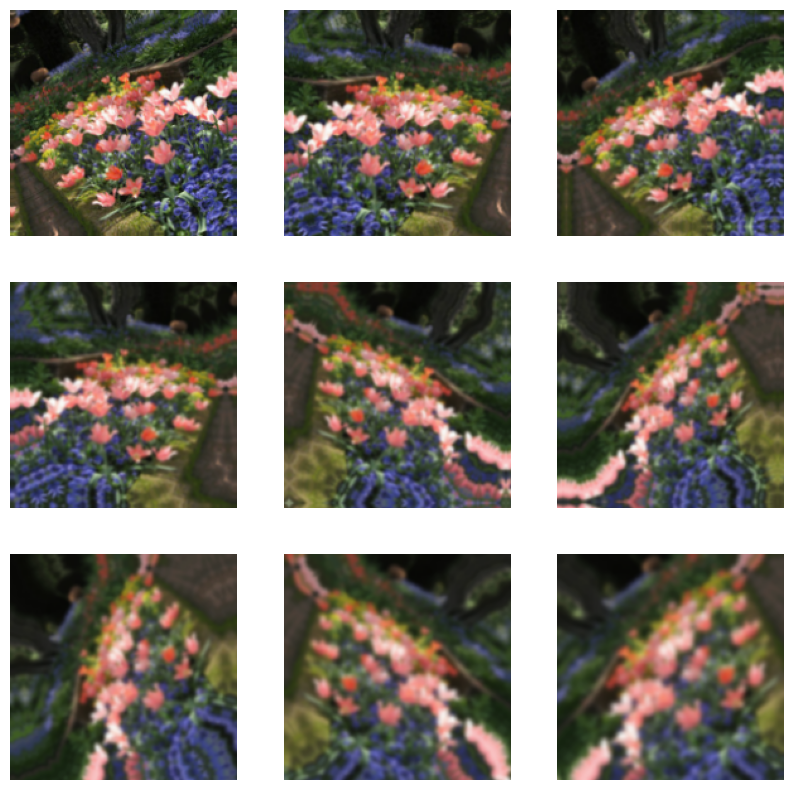

In [19]:
i=0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    original_image = images[0]  #Take only one image from the batch
    for i in range(9):
        images=data_augumentation(images)
        plt.subplot(3, 3, i+1)
        plt.imshow(images[0].numpy().astype('uint8'))  #Remove batch dimension
        plt.axis('off')

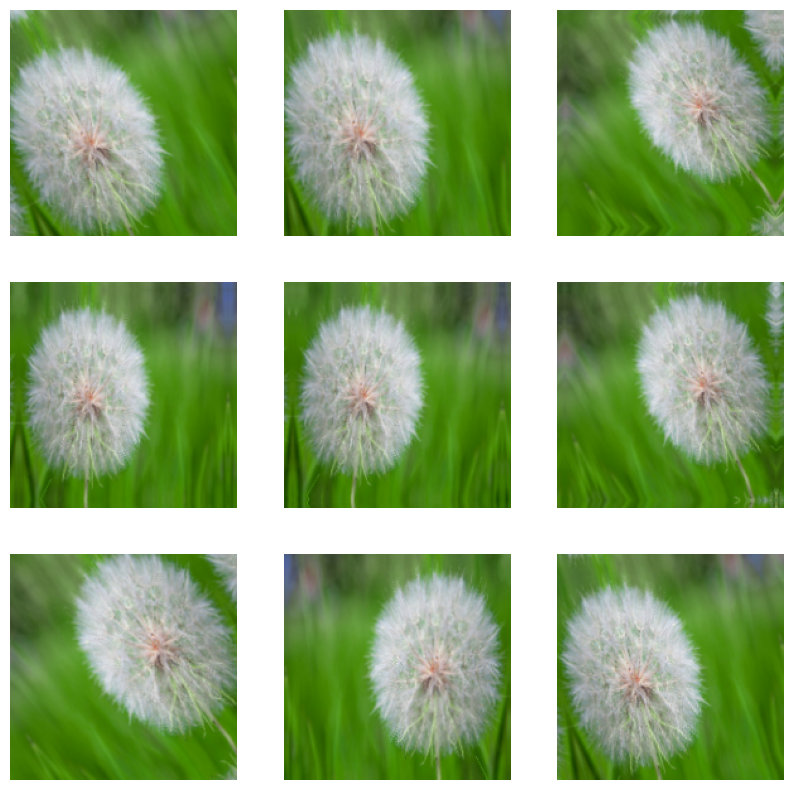

In [23]:
#or do
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    original_image = images[0]  #just one image
    for i in range(9):
        augmented = data_augumentation(tf.expand_dims(original_image, 0))  # Add batch dimension
        plt.subplot(3, 3, i+1)
        plt.imshow(augmented[0].numpy().astype('uint8'))  # Remove batch dimension
        plt.axis('off')

#takes less time

#Model Creation

In [24]:
model=Sequential([
    data_augumentation,
    layers.Rescaling(1./255), #Normalize pixel values (0–255 ➝ 0–1)
    Conv2D(16,3,padding='same',activation='relu'), #Conv Layer 1
    MaxPooling2D(), #Downsample
    Conv2D(32,3,padding='same',activation='relu'), #Conv Layer 2
    MaxPooling2D(), #Downsample
    Conv2D(64,3,padding='same',activation='relu'), #Conv Layer 3
    MaxPooling2D(), #Downsample
    Dropout(0.2), #Randomly drop 20% to prevent overfitting
    Flatten(), #Convert 3D to 1D
    Dense(128,activation='relu'), #Fully connected layer
    Dense(5) #Output layer: logits for 5 classes
])

#Feature Extraction: The Conv & Pool layers extract spatial features.
#Flattening: Turns 3D output into a 1D vector for classification.
#Dropout: Helps prevent overfitting.
#Dense Layers: Final decision-making part of the network.
#Output Layer (Dense(5)): Gives 5 raw scores (logits) — one for each class.



In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
              #Tells Keras to track accuracy during training and validation
              )

#Use Adam to optimize, calculate loss using raw logits vs integer class labels, and show accuracy
#If you had used Dense(5, activation='softmax'), you'd set from_logits=False

In [26]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
history=model.fit(train_ds,epochs=15, validation_data=val_ds)
#Trains your model for 15 epochs on train_ds
#Validates after each epoch using val_ds
#Saves training history (loss, accuracy, etc.) in the history object

Epoch 1/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - accuracy: 0.3614 - loss: 1.4455 - val_accuracy: 0.5168 - val_loss: 1.1811
Epoch 2/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.5611 - loss: 1.0780 - val_accuracy: 0.5527 - val_loss: 1.0877
Epoch 3/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.6215 - loss: 0.9609 - val_accuracy: 0.5863 - val_loss: 0.9885
Epoch 4/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.6482 - loss: 0.9080 - val_accuracy: 0.6431 - val_loss: 0.9040
Epoch 5/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.6869 - loss: 0.8358 - val_accuracy: 0.6188 - val_loss: 0.9432
Epoch 6/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.6752 - loss: 0.8503 - val_accuracy: 0.6895 - val_loss: 0.8250
Epoch 7/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 163s 2s/step - accuracy: 0.6936 - loss: 0.7689 - val_accuracy: 0.6825 - val_loss: 0.8138
Epoch 8/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - accuracy: 0.7008 - loss: 0.7642 - val_accu

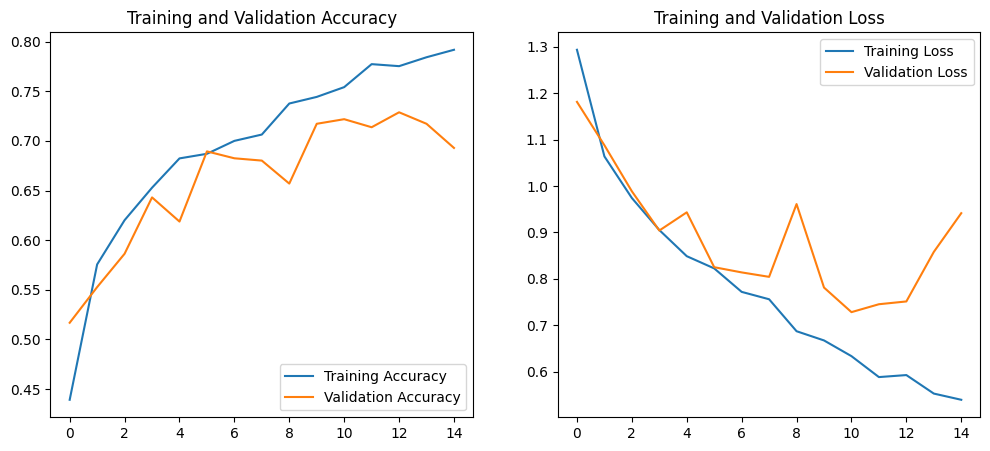

In [33]:
#plot training/validation performance over time
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [64]:
def classify_images(image_path):
  input_image=tf.keras.utils.load_img(image_path,target_size=(180,180)) #Load and resize
  input_image_array=tf.keras.utils.img_to_array(input_image) #Convert to array

  input_image_exp_dim=tf.expand_dims(input_image_array,0) #Add batch dim

  predictions=model.predict(input_image_exp_dim) #Model inference
  result=tf.nn.softmax(predictions[0]) #Convert logits to probabilities

  predicted_class = flower_names[np.argmax(result)]
  score = round(100 * np.max(result), 2)

  # Plot
  plt.figure(figsize=(3, 3))
  plt.imshow(input_image_array.astype("uint8"))
  plt.title(f"{predicted_class} ({score}%)", fontsize=14)
  plt.axis('off')
  plt.show()

  outcome='The image belong to '+predicted_class+'with a score of '+str(score)
  return outcome

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


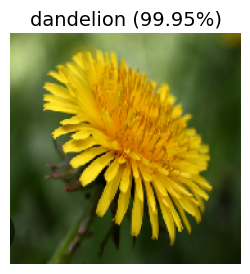

'The image belong to dandelionwith a score of 99.95'

In [65]:
classify_images('/content/samples/dandelion.png')

In [68]:
model.save('Flowers_Recog_Model.h5')